In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
script_dir = os.getcwd()

from sde.sde_learning_network_modified import (
    TimingCallback,
    SDEIdentification,
    ModelBuilder,
    SDEApproximationNetwork,
)

from sde.experiment_reports import (
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    histogram_data,
    plot_histogram
)

%load_ext autoreload
%autoreload 2

2025-01-13 16:38:36.181666: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 16:38:36.186415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-13 16:38:36.186432: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# notebook parameters
random_seed = 2
step_size = .25  # step size
n_pts = 20000     # number of points

n_layers = 1
n_dim_per_layer = 2**7

n_dimensions = 3

#ACTIVATIONS = tf.nn.leaky_relu
def ACTIVATIONS(x):
    j = tf.constant(1j, dtype=tf.complex64)
    x = tf.cast(x, dtype=tf.complex64)
    return tf.exp(j * x)
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
N_EPOCHS = 100

xlim = [-.3, .3]

# full covariance matrix, here SPD type
diffusivity_type = "spd"

tf.random.set_seed(random_seed)

In [3]:
# EXAMPLE 2

true_diffusivity_matrix = np.array([[1, 0, 0], [-5, 2, 0], [1, 0, 1]]) * 1e-1

rng = np.random.default_rng(random_seed)
true_diffusivity_matrix = rng.uniform(low=xlim[0], high=xlim[1], size=(n_dimensions, n_dimensions)) * np.tri(n_dimensions)
diag_tri = np.diag(np.diag(true_diffusivity_matrix))
true_diffusivity_matrix = true_diffusivity_matrix - diag_tri + np.abs(diag_tri)

# make SPD
true_diffusivity_matrix = true_diffusivity_matrix @ true_diffusivity_matrix.T

print(true_diffusivity_matrix)


def true_drift(x):
    return -x


def true_diffusivity(x):
    """
    This diffusivity is not differentiable (absolute value of x),
    so we need relu activations.
    """
    shift = true_diffusivity_matrix
    x = 0*x

    if x.shape[0] == 1:
        return shift
    else:
        return np.repeat(shift[np.newaxis, ...], x.shape[0], axis=0)


def true_drift_diffusivity(x, param=None):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=-1, high=1, n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=-1, high=1,
                                       n_pts=n_pts//10, rng=rng)
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

[[ 0.02045836 -0.03502162 -0.02678421]
 [-0.03502162  0.06355898  0.02981971]
 [-0.02678421  0.02981971  0.12453806]]
data shape (20000, 3)


In [4]:
# train model
No_of_tests = 1
cumulative_times = np.zeros((No_of_tests, N_EPOCHS))
losses = np.zeros((No_of_tests, N_EPOCHS))
val_losses = np.zeros((No_of_tests, N_EPOCHS))
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    # define model
    encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
    model = SDEApproximationNetwork(sde_model=encoder,
                                method="euler",
                                diffusivity_type=diffusivity_type)
    model.compile(optimizer=tf.keras.optimizers.Adamax())
    sde_i = SDEIdentification(model=model)
    timing_callback = TimingCallback()
    
    hist, _ = sde_i.train_model(x_data, y_data, step_size=step_sizes, validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE, callbacks=[timing_callback])
    
    cumulative_times[i,:] = timing_callback.epoch_times
    losses[i,:] = hist.history["loss"]
    val_losses[i,:] = hist.history["val_loss"]

    moving_avg = np.zeros(N_EPOCHS)
    min_moving_avg = float('inf')
    moving_avg_len = 5
    min_index = 0
    break_iterations = 5
    for j in range(N_EPOCHS):
        if j < moving_avg_len:
            moving_avg[j] = np.mean(val_losses[i,:j+1])
        else:
            moving_avg[j] = np.mean(val_losses[i,j-moving_avg_len+1:j+1])

        if moving_avg[j] < min_moving_avg:
            min_moving_avg = moving_avg[j]
            min_index = j

        if min_index + break_iterations < j:
            break

    val_loss_array = val_losses[i,:j]
    val_loss_min_index = np.argmin(val_loss_array)
    training_time[i] = cumulative_times[i,val_loss_min_index]
    val_loss[i] = val_losses[i,val_loss_min_index]


2025-01-13 16:38:39.433880: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-01-13 16:38:39.433916: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: KW61146
2025-01-13 16:38:39.433923: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: KW61146
2025-01-13 16:38:39.434009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 560.35.3
2025-01-13 16:38:39.434032: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 560.35.3
2025-01-13 16:38:39.434038: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 560.35.3
2025-01-13 16:38:39.434740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

training for 100 epochs with 18000 data points, validating with 2000


/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1067: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/douglaoj/miniconda

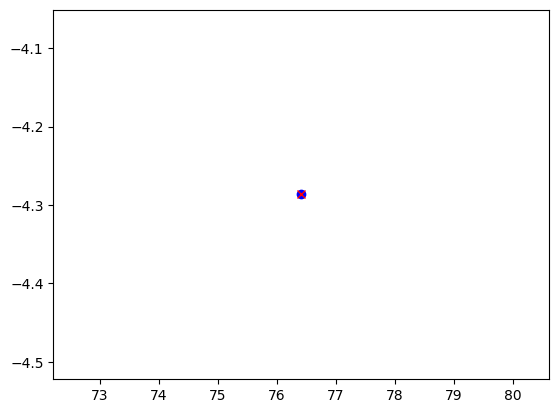

-4.286508261341623 76.41948127746582


In [5]:
# Calculate the mean
mean_training_time = np.mean(training_time)
mean_val_loss = np.mean(val_loss)

# Calculate the standard deviation above and below the mean for training_time
training_time_above = training_time[training_time > mean_training_time] - mean_training_time
training_time_below = mean_training_time - training_time[training_time < mean_training_time]

std_training_time_above = np.std(np.concatenate((training_time_above, -training_time_above)))
std_training_time_below = np.std(np.concatenate((training_time_below, -training_time_below)))

# Calculate points above and below the mean for val_loss
val_loss_above = val_loss[val_loss > mean_val_loss] - mean_val_loss
val_loss_below = mean_val_loss - val_loss[val_loss < mean_val_loss]

std_val_loss_above = np.std(np.concatenate((val_loss_above, -val_loss_above)))
std_val_loss_below = np.std(np.concatenate((val_loss_below, -val_loss_below)))

# Plot scatter points
plt.scatter(training_time, val_loss, color='blue', label='Data Points')

# Add non-symmetrical error bars (standard deviations)
plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[[std_training_time_below], [std_training_time_above]],  # Non-symmetrical x error
    yerr=[[std_val_loss_below], [std_val_loss_above]],  # Non-symmetrical y error
    fmt='x', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)
plt.show()

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "example4 - 3d sde-spd data.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_training_time},{mean_val_loss},{std_training_time_above},{std_training_time_below},{std_val_loss_above},{std_val_loss_below}\n")

print(mean_val_loss, mean_training_time)  

In [6]:
encoder.summary()

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 3)]          0           []                               
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 128)          512         ['GP_inputs[0][0]']              
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 128)          512         ['GP_inputs[0][0]']              
                                                                                                  
 GP_output_spd (Dense)          (None, 6)            774         ['GP_std_hidden_0[0][0]']        
                                                                                

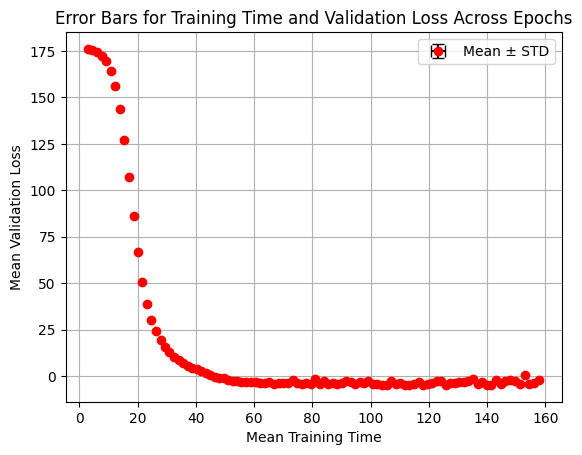

In [7]:
# Initialize arrays to store results
mean_training_time = np.zeros(N_EPOCHS)
mean_val_loss = np.zeros(N_EPOCHS)
std_training_time_above = np.zeros(N_EPOCHS)
std_training_time_below = np.zeros(N_EPOCHS)
std_val_loss_above = np.zeros(N_EPOCHS)
std_val_loss_below = np.zeros(N_EPOCHS)

# Iterate over epochs
for epoch in range(N_EPOCHS):
    training_time = cumulative_times[:, epoch]
    val_loss = val_losses[:, epoch]

    # Calculate mean
    mean_training_time[epoch] = np.mean(training_time)
    mean_val_loss[epoch] = np.mean(val_loss)

    # Calculate deviations for training_time
    training_time_above = training_time[training_time > mean_training_time[epoch]] - mean_training_time[epoch]
    training_time_below = mean_training_time[epoch] - training_time[training_time < mean_training_time[epoch]]
    std_training_time_above[epoch] = np.std(np.concatenate((training_time_above, -training_time_above)))
    std_training_time_below[epoch] = np.std(np.concatenate((training_time_below, -training_time_below)))

    # Calculate deviations for val_loss
    val_loss_above = val_loss[val_loss > mean_val_loss[epoch]] - mean_val_loss[epoch]
    val_loss_below = mean_val_loss[epoch] - val_loss[val_loss < mean_val_loss[epoch]]
    std_val_loss_above[epoch] = np.std(np.concatenate((val_loss_above, -val_loss_above)))
    std_val_loss_below[epoch] = np.std(np.concatenate((val_loss_below, -val_loss_below)))

plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[std_training_time_below, std_training_time_above],  # Non-symmetrical x error
    yerr=[std_val_loss_below, std_val_loss_above],  # Non-symmetrical y error
    fmt='o', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)

plt.xlabel('Mean Training Time')
plt.ylabel('Mean Validation Loss')
plt.title('Error Bars for Training Time and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)


In [8]:
# # export data
# data = pd.DataFrame({
#     "cum_time": mean_training_time,
#     "loss": mean_val_loss,
#     "std_training_time_above": std_training_time_above,
#     "std_training_time_below": std_training_time_below,
#     "std_val_loss_above": std_val_loss_above,
#     "std_val_loss_below": std_val_loss_below
# })

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, "example4 - 3d sde-spd data.csv")
# data.to_csv(output_path, index=False)

figures_per_row 3


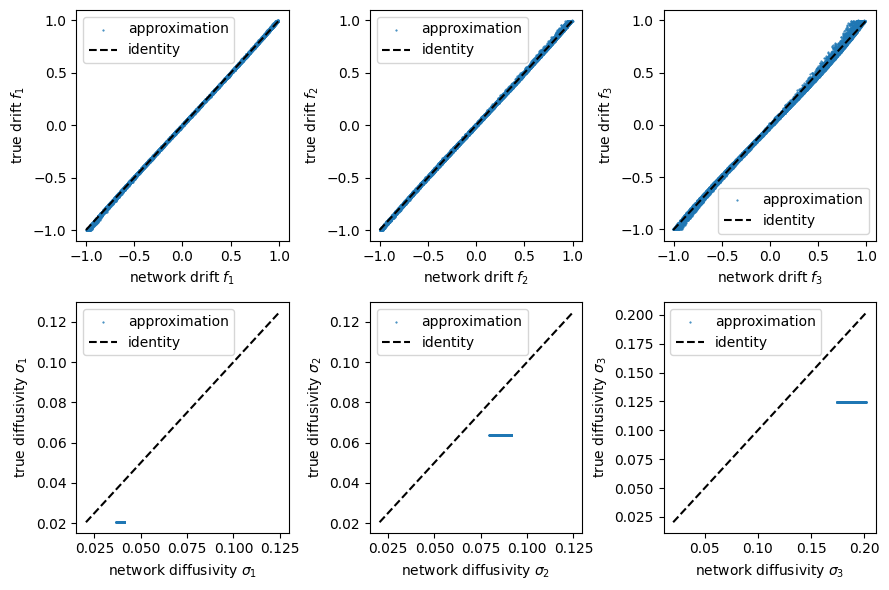

In [15]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

# for k in range(2):
#     ax[1, k].set_xlim([0, .5])
#     ax[1, k].set_ylim([0, .5])

# output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
# output_path = os.path.join(output_dir, "example4 - 3d sde-spd")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')

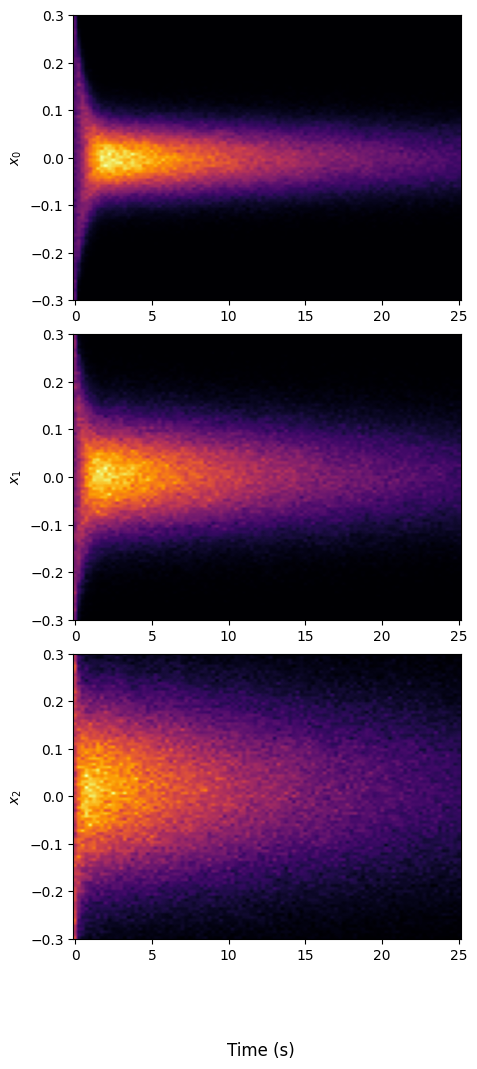

In [16]:
time = 100*step_size
SGD_paths = histogram_data(sde_i.drift_diffusivity, xlim[0], xlim[1], step_size, time, n_dimensions, random_seed)

plot_histogram(SGD_paths, xlim[0], xlim[1], step_size)

# output_dir = os.path.join(script_dir, 'histogram_data')
# output_path_true = os.path.join(output_dir, "ex4 - 3d sde-spd SGD.npy")
# np.save(output_path_true, SGD_paths)

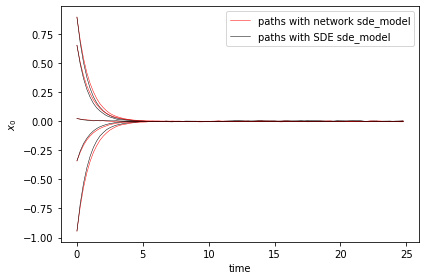

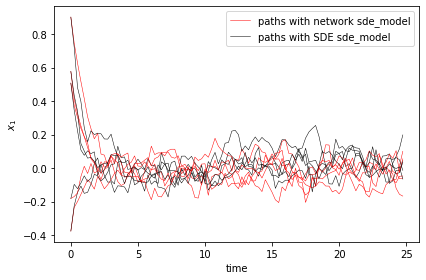

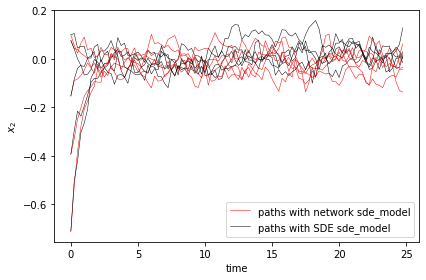

In [8]:
T_steps = 100
N_iterates = 5

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

for k in range(n_dimensions):
    plot_results_1d(time_steps, paths_network, paths_true, plot_dim=k, linewidth=.5);
    plt.gca().set_ylabel(fr"$x_{k}$");

[[0.00051161 0.00171289 0.00131282]
 [0.00171289 0.07605882 0.04110096]
 [0.00131282 0.04110096 0.03660936]]
(3, 3)
[[2.35487953e-05 7.83121662e-06 3.33019149e-06]
 [7.83121662e-06 3.96031518e-04 1.79625152e-04]
 [3.33019149e-06 1.79625152e-04 1.24797038e-04]]


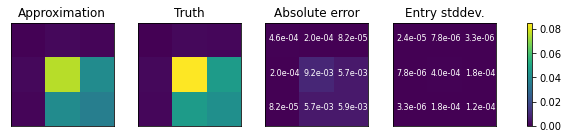

network_diffusivity_matrix
[[0.00051161 0.00171289 0.00131282]
 [0.00171289 0.07605882 0.04110096]
 [0.00131282 0.04110096 0.03660936]]
true_diffusivity_matrix
[[5.03102918e-05 1.90935554e-03 1.39463175e-03]
 [1.90935554e-03 8.52097424e-02 4.67775795e-02]
 [1.39463175e-03 4.67775795e-02 4.25135954e-02]]
error
[[4.61304599e-04 1.96464395e-04 8.18090947e-05]
 [1.96464395e-04 9.15092364e-03 5.67661725e-03]
 [8.18090947e-05 5.67661725e-03 5.90423064e-03]]


In [9]:
rng = np.random.default_rng(1)

sks = []
for k in range(1000):
    x0 = rng.uniform(low=xlim[0], high=xlim[1], size=(1,n_dimensions))
    _, sk = model.call_xn(x0)

    if np.prod(sk.shape) > np.prod(x0.shape):
        sk = tf.keras.backend.eval(tf.reshape(sk, (n_dimensions, n_dimensions)))
    else:
        sk = np.diag(tf.keras.backend.eval(sk)[0])
    sks.append(sk)
sk = np.mean(sks, axis=0)
skstd = np.std(sks, axis=0)

print(sk)

vlim = [np.min([np.min(sk), np.min(true_diffusivity_matrix)]), np.max([np.max(sk), np.max(true_diffusivity_matrix)])]
vlim[0] = 0

abserror = np.abs(sk-true_diffusivity_matrix)

print(abserror.shape)
print(skstd)

cmap = "viridis"
fig, ax = plt.subplots(1, 4, figsize=(9, 2))
ax[0].imshow(sk, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
ax[0].set_title("Approximation")
ax[1].imshow(true_diffusivity_matrix, vmin=vlim[0], vmax=vlim[1], cmap=cmap)
ax[1].set_title("Truth")
ax[2].imshow(abserror, vmin=vlim[0], vmax=vlim[1],  cmap=cmap)
ax[2].set_title("Absolute error")
sc=ax[3].imshow(skstd, vmin=vlim[0], vmax=vlim[1],  cmap=cmap)
ax[3].set_title("Entry stddev.")

for k1 in range(3):
    for k2 in range(3):
        if abserror[k2, k1] > 0:
            ax[2].text(k1-.4, k2+.025, f"{abserror[k2, k1]:.1e}", color="white", fontsize=8)
        else:
            ax[2].text(k1-.15, k2+.025, f"0.0", color="white", fontsize=8)
        if skstd[k2, k1] > 0:
            ax[3].text(k1-.4, k2+.025, f"{skstd[k2, k1]:.1e}", color="white", fontsize=8)
        else:
            ax[3].text(k1-.15, k2+.025, f"0.0", color="white", fontsize=8)

for k in range(4):
    ax[k].set_xticks([])
    ax[k].set_yticks([])
fig.tight_layout()
fig.colorbar(sc, ax=fig.get_axes())

plt.show()
print("network_diffusivity_matrix")
print(sk)
print("true_diffusivity_matrix")
print(true_diffusivity_matrix)
print("error")
print(abserror)

fig.savefig("figures/example_3dfull_matrixcompare.pdf")
fig.savefig("figures/example_3dfull_matrixcompare.png")

In [44]:
# sample from a single point, but more iterates
# and evaluate mean and standard deviations
N_iterates_single = 100
x0 = x_data[0, :].reshape(1, -1)

time_steps_single, paths_true_single = \
    generate_results(true_drift_diffusivity,
                     step_size, x0, rng,
                     T_steps=T_steps, N_iterates=N_iterates_single);

paths_network_single = sde_i.sample_path(x0, step_size,
                                          NT=T_steps-1, N_iterates=N_iterates_single,
                                          diffusivity_type=diffusivity_type)

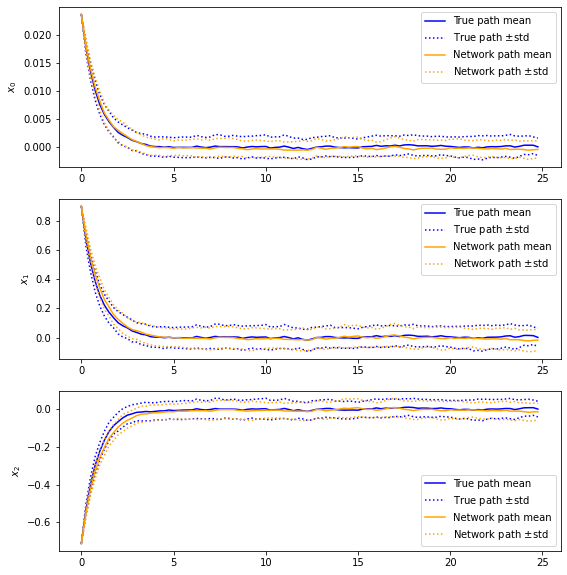

In [53]:
fig, ax = plt.subplots(n_dimensions, 1, figsize=(3*n_dimensions, 10))
for k in range(n_dimensions):
    plot_results_statistics(ax[k], time_steps_single[0], paths_true_single,
                            dimension=k, color="blue", label="True path")
    plot_results_statistics(ax[k], time_steps_single[0], paths_network_single,
                            dimension=k, color="orange", label="Network path")
    ax[k].legend()
    ax[k].set_ylabel(fr"$x_{k}$")